# import Library

In [1]:
import sys

sys.path.append('../')
from my_library.library import *
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from my_library.funcs import *
from scipy import fftpack





# path ubu

In [ ]:
path_daw = '/home/hipro/デスクトップ/StockPriceData/Stock_index/DAW_10years.csv'
path_tpx = '/home/hipro/デスクトップ/StockPriceData/Stock_index/TOPIX_10years.csv'


# path mac

In [2]:
path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/rince/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_doll = '/Users/rince/Desktop/StockPriceData/Stock_index/doll_yen_bid.csv'


path_gold = '/Users/rince/Desktop/StockPriceData/Stock_index/gold_chusin.csv'
path_kawase = '/Users/rince/Desktop/StockPriceData/Stock_index/quote.csv'

# path win

In [2]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'

path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'

path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'
save_path = '/Users/Owner/Desktop/program/Sotsuron/code/pickles'

# Learn XGB

In [3]:
lx = LearnXGB(num_class=3)
lx.learn_xgb(path_tpx,path_daw,test_rate=0.7,verbose=False)

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# index 投信 

In [ ]:
tps = TPXSimulation()
tps.simulate(path_tpx,path_daw,start_year=2022,end_year=2022,start_month=1,end_month=12)
pr = tps.return_profit_rate()

# DAW simulte

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
ds = DawSimulation()
ds.simulate(path_tpx,path_daw,strategy='reverse',start_year=2021,end_year=2021,start_month=1,end_month=12)


# Random simulate

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
rs = RandomSimulation()
rs.simulate(path_tpx_sim,path_daw_sim,start_year=2022,end_year=2022,start_month=1,end_month=5)

# Technical simulate

In [ ]:
ts = TechnicalSimulation()
plt.grid()
ts.simulate(path_tpx,path_daw,start_year=2021,end_year=2021,start_month=1,end_month=12)
pr_log_ts = ts.pr_log

# predict tomorrow

In [ ]:
path_tpx_sim, path_daw_sim = return_latest_data_path('TOPIX')
lx.predict_tomorrow(path_tpx_sim,path_daw_sim,alpha=0.6,strategy='normal',start_year=2022,start_month=1,end_month=6,is_observed=True)

# FFT Simulation new
is_abs = True

# 業種別　解析

In [23]:
df_dict,FILE = get_gyosyu_df()

In [ ]:
for i,key in enumerate(df_dict):
    xs = XGBSimulation2(lx)
    xs.simulate(FILE[i],path_daw,start_year=2019,is_validate=True)
    print("------------")
    print(key)
    print(xs.accuracy_df)

# 四半期のsim

In [6]:
ffs_19 = load_pickle(save_path+'/ffs_2019.pickle')
ffs_20 = load_pickle(save_path+'/ffs_2020.pickle')
ffs_21 = load_pickle(save_path+'/ffs_2021.pickle')
ffs_good = load_pickle(save_path+'/ffs_dict_good.pickle')

# load pickle

In [3]:
def split_df(df,start_year,end_year,start_month,end_month):
    df = df[df.index.year<=end_year]
    df = df[df.index.year>=start_year]
    df = df[df.index.month<=end_month]
    if start_month>0:
        df = df[df.index.month>=start_month]
    return df

def make_value_list(lx,start_year,end_year,path_tpx,path_daw,alpha=0.34,width=20,stride=10,start_month=1,end_month=12):

    lc_dummy = LearnClustering(width=width)
    df_con = lc_dummy.make_df_con(path_tpx,path_daw)
    
    df_con = split_df(df_con,start_year,end_year,start_month,end_month)
    
    x_,z_ = lc_dummy.make_x_data(df_con['close'],stride=stride,test_rate=1.0,width=width)
    length = len(z_)
    value_list = []

    for i in range(length):
        for strategy in ['normal','reverse']:
            try:
                xl = XGBSimulation2(lx,alpha=alpha)
                xl.simulate(path_tpx,path_daw,strategy=strategy,is_validate=True,start_year=start_year,end_year=end_year,df_=z_[i])
                
                trade_log =  xl.trade_log
                total_profit = trade_log['total_profit'].values[0]
                stock_wave = z_[i]
                vt = ValueTable(strategy,alpha,total_profit,trade_log,stock_wave)
                value_list.append(vt)
                
            except Exception as e:
                print(e)
                continue

    return value_list

def return_clx(Value_list):
    Value_good = sorted(Value_list,key=lambda x :x[2],reverse=True)
    Value_bad = sorted(Value_list,key=lambda x :x[2],reverse=False)
    ng = []
    rg = []
    nb = []
    rb = []
    
    # 1sigam = 外れ値 として処理する
    prf_list=[]
    for vg in Value_good:
        total_profit = vg.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for idx,v in enumerate(Value_good):
        if v.total_profit<=0:break
        # if np.abs(st_prf[idx]) >=1:continue    

        df = v.stock_wave
        strategy = v.strategy
        # print(df)
        # break
        if strategy=="normal":
            ng.append(standarize(df))
        else:
            rg.append(standarize(df))

    prf_list=[]
    for vb in Value_bad:
        total_profit = vb.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for v in Value_bad:
        if v.total_profit>=0 :break
        # if np.abs(st_prf[idx]) >=1:continue  
        
        df = v.stock_wave
        strategy = v.strategy

        if strategy=="normal":
            nb.append(standarize(df))
        else:
            rb.append(standarize(df))

    x_ng = make_easy_x(ng)
    x_nb = make_easy_x(nb)
    x_rg = make_easy_x(rg)
    x_rb = make_easy_x(rb)
    return x_ng,x_nb,x_rg,x_rb

def return_ffs(lx,x_ng,x_nb,x_rg,x_rb,FFT_obj,width=20,stride=10):


    log_dict = {}
    cs_dict = {}
    ffs_dict = {}
    

    random_state=0

    alpha = 0.33
    n_cluster = 1
        
    Fstrategies = []
    Cstrategies = []
    Phases = []
    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    fft_dummy = FFT_obj(lx,None,width=width)
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            spe = fft_dummy.make_spectrum(wave)
            F,Amp = fft_dummy.do_fft(wave)
            F = F[:len(F)//2]
            phase = np.degrees(np.angle(F))
            strategy = strategy_list[j]
            fs  = Fstrategy(strategy,alpha,spe)
            cs = Fstrategy(strategy,alpha,wave)
            ph = Fstrategy(strategy,alpha,phase)
            Fstrategies.append(fs)
            Cstrategies.append(cs)
            Phases.append(ph)
        j+=1

    return Fstrategies,Phases

def return_fft_list(lx,x_,FFT_obj,width=20):

    fft_list = []
    fft_dummy = FFT_obj(lx,None,width=width)
    for wave in x_:
        spe = fft_dummy.make_spectrum(wave)
        fft_list.append(spe)
        
    return fft_list        

# あらかじめ 1Q 単位のvalue_listを作っておく

In [27]:


lx_dict = {}
value_dict = {}

width  = 40
stride = 10
lx_dummy = LearnXGB(num_class=3)
x_train,y_train,_,_= lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=1.0)
_,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=0.9)

# value_list 学習させるために 1Q ずらした lx が必要
x_train_ = split_df(x_train,2005,2016,1,12)
y_train_ = y_train[:len(x_train_)]
lx = LearnXGB(num_class=3)
lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)
lx_dict[str(2016)+'4Q'] = lx

for year in [2017,2018,2019,2020,2021]:
    for month in [1,4,7,10]:
        start_year = 2005
        end_year = year
        start_month = 1
        end_month = month + 2
        Q = ''
        
        x_train_ = split_df(x_train,start_year,end_year,start_month,end_month)
        y_train_ = y_train[:len(x_train_)]
        
        
        lx = LearnXGB(num_class=3)
        lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)
        
        
        
        if month==1:
            Q = '1Q'
        elif month==4:
            Q = '2Q'
        elif month==7:
            Q = '3Q'
        elif month==10:
            Q = '4Q'
            
            
        last_key = next(reversed(lx_dict),None)
        value_list = make_value_list(lx_dict[last_key],year,year,path_tpx,path_daw,width=width,stride=stride,start_month=month,end_month=month+2)
        value_dict[str(year)+Q] = value_list
        
        lx_dict[str(year)+Q] = lx
        


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

In [5]:
def concat_list(key_list,value_dict):
    value_list = []
    for key in key_list:
        v_lis = value_dict[key]
        for v in v_lis:
            value_list.append(v)
    return value_list

In [28]:

ffs_dict = {}
trade_dict = {}
FFT_obj = FFTSimulation
width  = 40
stride = 10
lx_dummy = LearnXGB(num_class=3)
x_train,y_train,_,_= lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=1.0)
_,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=0.9)


for year in [2018,2019,2020,2021]:
    print(year)
    for month in [1,4,7,10]:
        # ここでキュー更新
        start_month=month
        end_month = month+2
        start_year = year
        end_year = year
        
        if month==1:
            Q = '1Q'
        elif month==4:
            Q = '2Q'
        elif month==7:
            Q = '3Q'
        elif month==10:
            Q = '4Q'
            
        preQ = ''
        lx_ = None
        if Q == '1Q':
            key_list = [
                str(year-1)+'1Q',
                str(year-1)+'2Q',
                str(year-1)+'3Q',
                str(year-1)+'4Q',
                ]
            lx_ = lx_dict[str(year-1)+'4Q']
            value_list = concat_list(key_list,value_dict)
            
        elif Q == '2Q':
            preQ = '1Q'
            key_list = [
                str(year-1)+'2Q',
                str(year-1)+'3Q',
                str(year-1)+'4Q',
                str(year)+'1Q',
                ]
            lx_ = lx_dict[str(year)+'1Q']
            value_list = concat_list(key_list,value_dict)
        
        elif Q == '3Q':
            key_list = [
                str(year-1)+'3Q',
                str(year-1)+'4Q',
                str(year)+'1Q',
                str(year)+'2Q',
                ]
            lx_ = lx_dict[str(year)+'2Q']
            value_list = concat_list(key_list,value_dict)
        
        elif Q == '4Q':
            key_list = [
                str(year-1)+'4Q',
                str(year)+'1Q',
                str(year)+'2Q',
                str(year)+'3Q',
                ]
            lx_ = lx_dict[str(year)+'3Q']
            value_list = concat_list(key_list,value_dict)
        
        x_ng,x_nb,x_rg,x_rb = return_clx(value_list)

        try:
            Fstrategies,_ = return_ffs(lx_,x_ng,x_nb,x_rg,x_rb,FFT_obj,width=width,stride=stride)
        except Exception as e:
            print(e)
            last_key = next(reversed(ffs_dict),None)
            Fstrategies = ffs.Fstrategies
            
        
        ffs = FFT_obj(lx,Fstrategies,width=width)
        ffs.simulate(path_tpx,path_daw,start_year=year,end_year=year,start_month=start_month,end_month=end_month,is_validate=True)
        
        ffs_dict[str(year)+Q] = ffs
        trade_dict[str(year)+Q] = ffs.trade_log


2018
2019


In [ ]:
for idx,key in enumerate(trade_dict):
    print(trade_dict[key])

   total_profit  profit rate  trade_count  max_profit  min_profit  \
1        -184.0        -7.36            3        15.0      -139.0   

   mean_profit  cant_buy_count  
1   -61.333333               0  
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -21.0        -0.84            2        48.0       -69.0   

   mean_profit  cant_buy_count  
1        -10.5               0  
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1          47.0         1.88            3        28.0         0.0   

   mean_profit  cant_buy_count  
1    15.666667               0  
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1        -105.0         -4.2            4         0.0       -53.0   

   mean_profit  cant_buy_count  
1       -26.25               0  
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1             0          0.0            0           0           0   

   mean_profit  cant_buy_count  
1       

In [13]:
v_ = make_value_list(lx_,2018,2018,path_tpx,path_daw,alpha=0.34,width=4,stride=10,start_month=1,end_month=12)
v_


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


[ValueTable(strategy='normal', alpha=0.34, total_profit=0.0, trade_log=   total_profit  profit rate  trade_count  max_profit  min_profit  \
 1           0.0          0.0            1         0.0         0.0   
 
    mean_profit  cant_buy_count  
 1          0.0               0  , stock_wave=day
 2018-01-04    1920.0
 2018-01-05    1935.0
 2018-01-09    1945.0
 2018-01-10    1949.0
 Name: close, dtype: float64),
 ValueTable(strategy='reverse', alpha=0.34, total_profit=0, trade_log=   total_profit  profit rate  trade_count  max_profit  min_profit  \
 1             0          0.0            0           0           0   
 
    mean_profit  cant_buy_count  
 1            0               0  , stock_wave=day
 2018-01-04    1920.0
 2018-01-05    1935.0
 2018-01-09    1945.0
 2018-01-10    1949.0
 Name: close, dtype: float64),
 ValueTable(strategy='normal', alpha=0.34, total_profit=18.0, trade_log=   total_profit  profit rate  trade_count  max_profit  min_profit  \
 1          18.0         0.72 

In [15]:
len(v_)

50

スペクトルの差分をとって強調すればわかりやすいんじゃね？

# make_spectrum 直す

In [165]:
ffs_dict

{2017: <my_library.library.FFTSimulation at 0x14b90e35880>,
 2018: <my_library.library.FFTSimulation at 0x14b900cf190>,
 2019: <my_library.library.FFTSimulation at 0x14b9300c1f0>,
 2020: <my_library.library.FFTSimulation at 0x14b90cbcc10>}

power spectrum
st = 0


<Figure size 432x288 with 0 Axes>

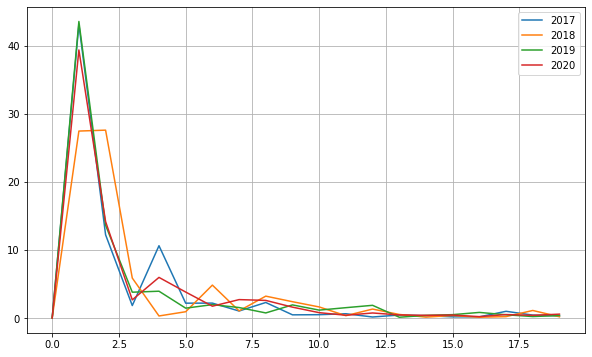

st = 1


<Figure size 432x288 with 0 Axes>

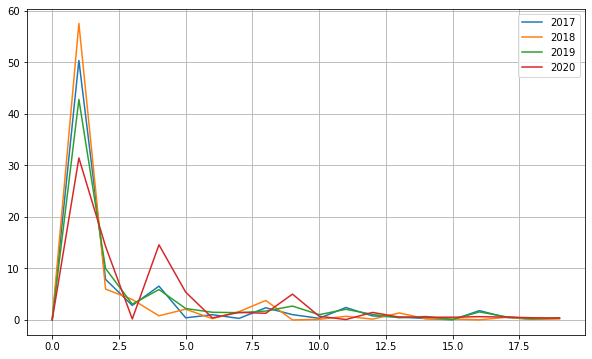

st = 2


<Figure size 432x288 with 0 Axes>

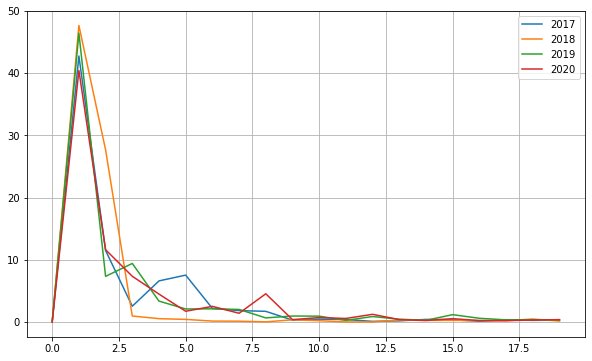

st = 3


<Figure size 432x288 with 0 Axes>

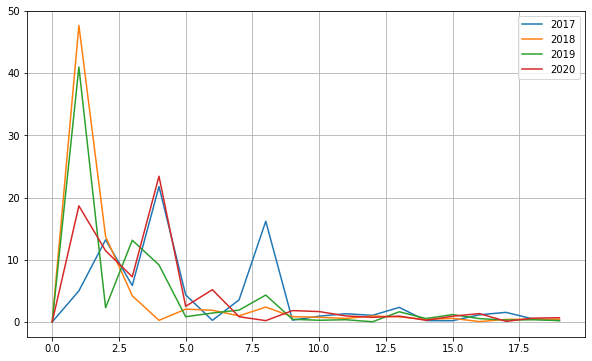

In [7]:
# ffs_dict = {}
# trade_dict = {}
# phase_dict = {}
# # 各年のパワースペクトルの二乗誤差最小のwidth, strideを求める
# mse_dict = {}
# width = 40
# stride = 10

# for year in [2017,2018,2019,2020]:

#     print(year)
#     value_list = make_value_list(lx,year,year,path_tpx,path_daw,width=width,stride=stride)
#     x_ng,x_nb,x_rg,x_rb = return_clx(value_list)
#     ffs, trade_log, phases = return_ffs(year+1,year+1,lx,x_ng,x_nb,x_rg,x_rb,FFTSimulation,width=width,stride=stride)
#     ffs_dict[year+1] = ffs
#     trade_dict[year+1] = trade_log
#     phase_dict[year+1] = phases

print("power spectrum")
for st in [0,1,2,3]:
    plt.clf()
    print("st =",st)
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    for year in [2017,2018,2019,2020]:
        spe =  ffs_dict[year].Fstrategies[st].spectrum
        ax.plot(spe,label=str(year))
    ax.legend()
    ax.grid()
    plt.show()

# print("phase spectrum")
# for st in [0,1,2,3]:
#     plt.clf()
#     print("st =",st)
#     fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
#     for year in [2018,2019,2020,2021]:
#         spe =  phase_dict[year][st].spectrum
#         ax.plot(spe,label=str(year))
#     ax.grid()
#     ax.legend()
#     plt.show()


In [66]:
x_rb.shape

(7, 40)

# normal plot spectrum

0 : normal good \
1 : normal bad \
2 : reverse good \
3 : reverse bad

離散的なプロットのしかた

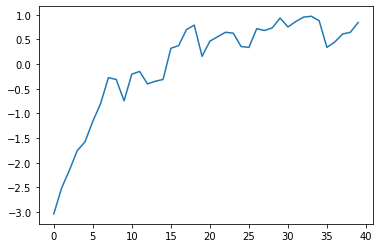

In [71]:
plt.plot(x_ng[0])

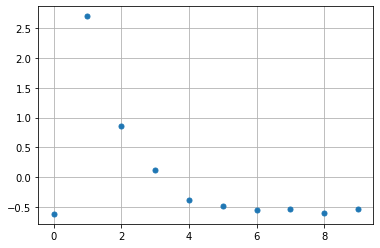

In [31]:
plt.plot(ffs.Fstrategies[0].spectrum,'.',markersize=10)
plt.grid()

# ケプストラム分析

In [10]:
# リニア値をdB変換
def db(x, dBref):
    y = 20 * np.log10(x / dBref)                      # リニア値をdB値に変換
    return y                                          # dB値を返す


In [35]:
def return_ceps_norm(spectrum):

    # ケプストラム分析
    spec_db = db(spectrum, 2e-5)                              # スペクトルを対数(dB)にする(0dB=20[μPa])
    ceps_db = np.real(fftpack.ifft(spec_db))                # 対数スペクトルを逆フーリエ変換してケプストラム波形を作る
    ceps_db_low = fftpack.fft(ceps_db) 
    ceps_norm = norm(ceps_db_low)                           # ケプストラム波形を再度フーリエ変換してスペクトル包絡を得る
    return ceps_norm



power spectrum
st = 0


<Figure size 432x288 with 0 Axes>

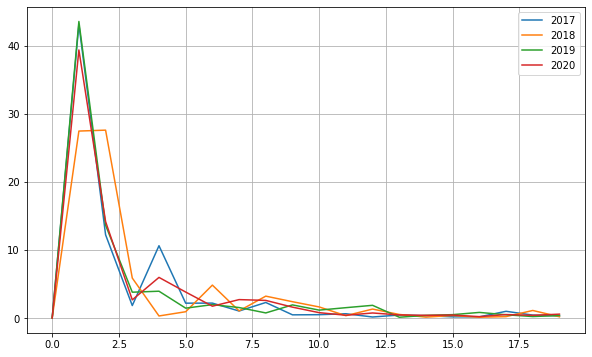

st = 1


<Figure size 432x288 with 0 Axes>

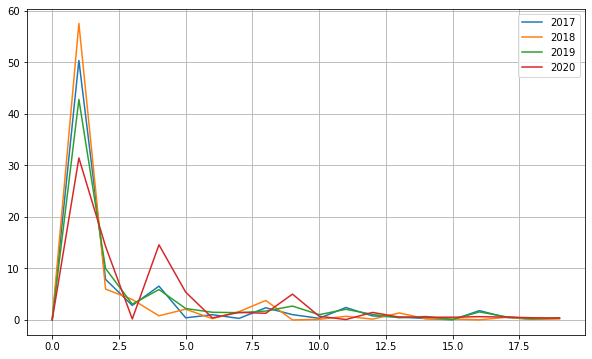

st = 2


<Figure size 432x288 with 0 Axes>

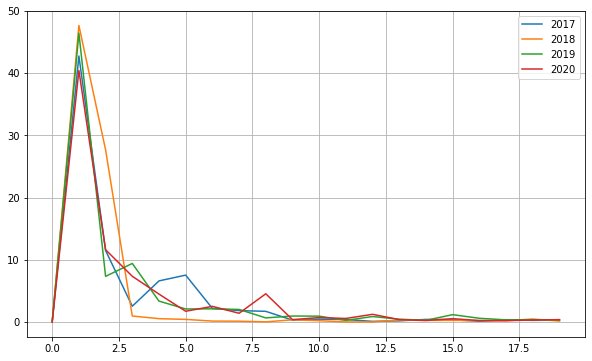

st = 3


<Figure size 432x288 with 0 Axes>

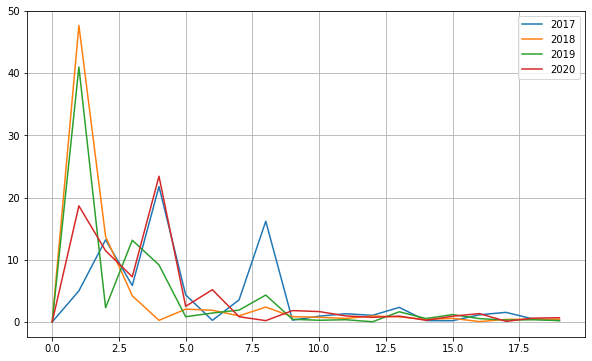

In [36]:
print("power spectrum")
for st in [0,1,2,3]:
    plt.clf()
    print("st =",st)
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    for year in [2017,2018,2019,2020]:
        spe =  ffs_dict[year].Fstrategies[st].spectrum
        ax.plot(spe,label=str(year))
    ax.legend()
    ax.grid()
    plt.show()

cepstrum
st = 0


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:133

<Figure size 432x288 with 0 Axes>

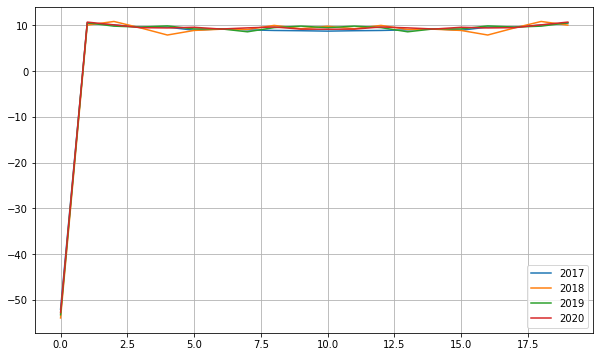

st = 1


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:133

<Figure size 432x288 with 0 Axes>

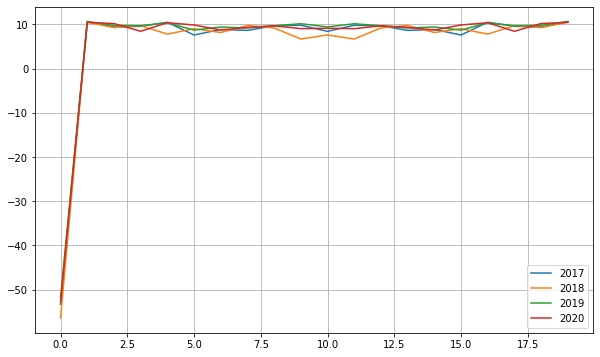

st = 2


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Temp/ipykernel_1776/3146644084.py:3: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(x / dBref)                     

<Figure size 432x288 with 0 Axes>

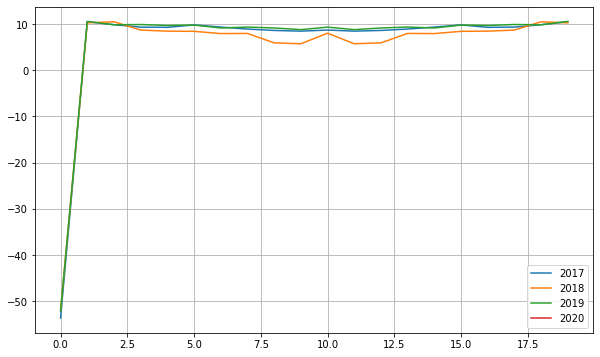

st = 3


C:\Users\Owner\AppData\Local\Temp/ipykernel_1776/3146644084.py:3: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(x / dBref)                      # リニア値をdB値に変換
c:\Users\Owner\Desktop\program\Sotsuron\code\model\New_XGB\..\my_library\funcs.py:484: RuntimeWarning: invalid value encountered in true_divide
  spectrum = spectrum / (N/2)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Owner\AppData\Local\Temp/ipykernel_1776/3146644084.py:3: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(x / dBref)                      # リニア値をdB値に変換
c:\Users\Owner\Desktop\program\Sotsuron\code\model\New_XGB\..\my_library\funcs.py:484: RuntimeWarning: invalid value encountered in true_divide
  spectrum = spectrum / (N/2)
C:\User

<Figure size 432x288 with 0 Axes>

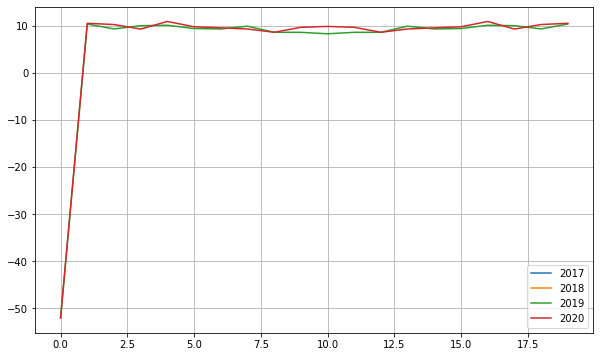

In [38]:
print("cepstrum")
for st in [0,1,2,3]:
    plt.clf()
    print("st =",st)
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    for year in [2017,2018,2019,2020]:
        spe =  ffs_dict[year].Fstrategies[st].spectrum
        ceps_norm = return_ceps_norm(spe)
        ax.plot(ceps_norm,label=str(year))
    ax.legend()
    ax.grid()
    plt.show()

In [40]:
trade_dict

{2017:    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1         -71.0        -2.84            9        20.0       -24.0   
 
    mean_profit  cant_buy_count  
 1    -7.888889               0  ,
 2018:    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1        -216.0        -8.64           17        48.0      -113.0   
 
    mean_profit  cant_buy_count  
 1   -12.705882               0  ,
 2019:    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1          34.0         1.36           26        35.0       -73.0   
 
    mean_profit  cant_buy_count  
 1     1.307692               0  ,
 2020:    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1          75.0          3.0           37        93.0      -174.0   
 
    mean_profit  cant_buy_count  
 1     2.027027               0  }